In [1]:
%matplotlib inline
import numpy as np

import readdy_learn.analyze.tools as pat
import readdy_learn.generate.generate_tools.kinetic_monte_carlo as kmc
from readdy_learn.analyze.sklearn import BasisFunctionConfiguration, CV, get_dense_params, ReaDDyElasticNetEstimator
from readdy_learn.sample_tools import Suite
import readdy_learn.analyze.derivative as deriv

import matplotlib.pyplot as plt

In [48]:
timestep = 1e-4
n_steps=100
tol=1e-6
# interp_degree >= 0: interpolate with polynomials (dont use this with high degree)
# interp_degree < 0: interpolate with curve fit (this is also shit)
# interp_degree = 'pw_linear': piecewise linear interpolation of counts (dont use this)
# interp_degree = 'SINDy': maybe this works, todo
interp_degree='pw_linear'
desired_rates = np.array([.02, .02, 1e-2, 1e-2, 0, 0])

In [49]:
def set_up_system(init_state=[[70, 50, 30, 80]]):
    sys = kmc.ReactionDiffusionSystem(n_species=4, n_boxes=1, diffusivity=[[[0.]], [[0.]], [[0.]], [[0.]]],
                                      init_state=init_state, species_names=["A", "B", "C", "D"])
    sys.add_conversion("A", "D", np.array([desired_rates[0]]))
    sys.add_conversion("D", "A", np.array([desired_rates[1]]))
    sys.add_fusion("A", "B", "C", np.array([desired_rates[2]]))
    sys.add_fission("C", "D", "B", np.array([desired_rates[3]]))

    bfc = BasisFunctionConfiguration(n_species=sys.n_species)
    bfc.add_conversion(0, 3)  # A -> D
    bfc.add_conversion(3, 0)  # D -> A
    bfc.add_fusion(0, 1, 2) # A + B -> C
    bfc.add_fission(2, 3, 1) # C -> D + B
    bfc.add_fission(2, 0, 1) # C -> A + B, nope
    bfc.add_conversion(0, 1) # A -> B, nope
    return sys, bfc

In [50]:
def get_traj(sys, bfc, verbose=True, n_frames=None, timestep=None):
    counts, times, config = sys.get_counts_config(n_frames=n_frames, timestep=timestep)
    traj = pat.Trajectory.from_counts(config, counts, times[1] - times[0], verbose=verbose, 
                                      interp_degree=interp_degree)
    traj.update()
    return traj

In [51]:
train_system, bfc = set_up_system()
train_system.simulate(n_steps)
train_traj = get_traj(train_system, bfc, timestep=timestep)

[KMC] [2017-10-24 10:43:51] [INFO] Simulate for 100 steps
[KMC] [2017-10-24 10:43:51] [INFO] got time step 0.0001 and n_frames 130236


max counts = 82.0, min nonzero counts = 3.0


In [52]:
test_trajs = []
nmax = 100
for _ in range(1):
    init = [[np.random.randint(0, nmax), np.random.randint(0, nmax),  
             np.random.randint(0, nmax), np.random.randint(0, nmax)]]
    init = [[52, 42, 81, 7]]
    print("setting up trajectory with init state {}".format(init))
    test_system, _ = set_up_system(init_state=init)
    test_system.simulate(n_steps)
    test_traj = get_traj(test_system, bfc, timestep=1e-3)
    test_trajs.append(test_traj)

[KMC] [2017-10-24 10:43:51] [INFO] Simulate for 100 steps
[KMC] [2017-10-24 10:43:51] [INFO] got time step 0.001 and n_frames 23018


setting up trajectory with init state [[52, 42, 81, 7]]
max counts = 113.0, min nonzero counts = 4.0


[KMC] [2017-10-24 10:43:52] [INFO] got time step 0.0001 and n_frames 130236
[KMC] [2017-10-24 10:43:52] [INFO] got time step 0.0001 and n_frames 230173


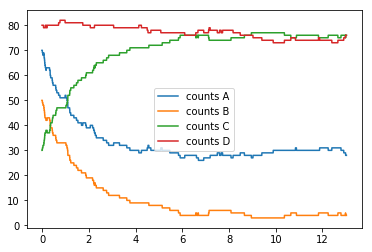

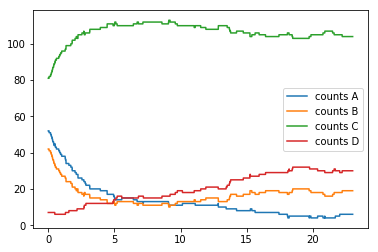

In [53]:
# plot concentrations
suite = Suite(set_up_system)
suite.plot_concentrations(train_system, timestep)
suite.plot_concentrations(test_system, timestep)

In [54]:
estimator = suite.get_estimator(train_system, bfc, timestep, interp_degree=-1)
dX = estimator.trajs[0].calculate_dX()

[KMC] [2017-10-24 10:43:59] [INFO] got time step 0.0001 and n_frames 130236


copt=[  6.80363221e+01  -9.02806198e+04   1.40582691e+06  -2.40378503e+10
   1.30919942e+14]
copt=[  4.78266639e+01  -9.61713791e+04   3.44476967e+05  -7.18705379e+09
   3.93310872e+13]
copt=[  4.13074633e+01   4.49228623e+02   1.74440966e+06  -2.82544520e+10
   1.46542056e+14]
copt=[  8.24791649e+01  -2.69286401e+02  -1.56718901e+05   2.70463589e+09
  -1.96518803e+13]


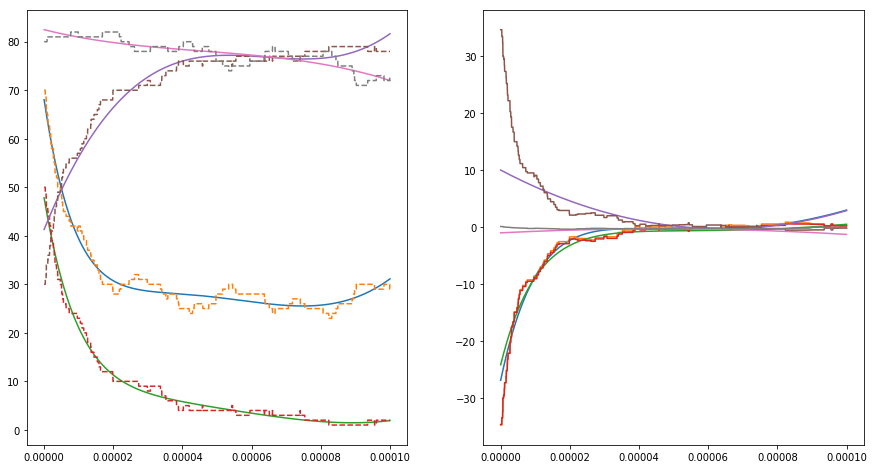

In [31]:
from scipy import interpolate
from scipy import optimize
traj = estimator.trajs[0]

dt = traj.time_step
X = np.linspace(0, 1, num=traj.n_time_steps) * dt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

theta = estimator.get_theta(traj.counts)
theta = np.transpose(theta, axes=(0, 2, 1))
dx = theta.dot(desired_rates)

for s in range(traj.n_species):
    counts = traj.counts[:, s]
    indices = 1 + np.where(counts[:-1] != counts[1:])[0]
    indices = np.insert(indices, 0, 0)
    indices = np.append(indices, len(counts) - 1)
    
    fun = lambda t, b, c, d, e, g: b*np.exp(c*t) + d * t + e * t*t + g * t*t*t
    
    dfun_dt = lambda t, b, c, d, e, g: b*c*np.exp(c*t) + d + 2*e*t + 3*g*t*t
    dfun_da = lambda t, b, c, d, e, g: 0*t
    dfun_db = lambda t, b, c, d, e, g: np.exp(c*t)
    dfun_dc = lambda t, b, c, d, e, g: t*b*np.exp(c*t)
    dfun_dd = lambda t, b, c, d, e, g: t
    dfun_de = lambda t, b, c, d, e, g: t*t
    dfun_dg = lambda t, b, c, d, e, g: t*t*t
    derivatives = [dfun_db, dfun_dc, dfun_dd, dfun_de, dfun_dg]
    def jac(t, b, c, d, e, g):
        result = np.array([np.array(f(t,b,c,d,e,g)) for f in derivatives])
        return result.T
    
    copt, _ = optimize.curve_fit(fun, X, counts, maxfev=300000, jac=jac)
    print("copt={}".format(copt))
    ff = lambda t : fun(t, *copt)
    dff = lambda t : dfun_dt(t, *copt)
    ax1.plot(X, ff(X))
    ax1.plot(X, counts, '--')
    
    #ax2.plot(X, dff(X))
    ax2.plot(X, np.gradient(ff(X), axis=0) / dt)
    ax2.plot(X, dx[:, s])
plt.show()

iteration    1: relative change = 8.552e-02, gradient norm = 1.612e+03
iteration    2: relative change = 2.917e-02, gradient norm = 8.570e+02
WARNING - convergence to tolerance not achieved!
iteration    3: relative change = 4.450e-03, gradient norm = 6.703e+02
WARNING - convergence to tolerance not achieved!
iteration    4: relative change = 2.804e-03, gradient norm = 4.932e+02
WARNING - convergence to tolerance not achieved!
iteration    5: relative change = 1.412e-03, gradient norm = 4.358e+02
WARNING - convergence to tolerance not achieved!
iteration    6: relative change = 6.248e-04, gradient norm = 5.375e+02
WARNING - convergence to tolerance not achieved!
iteration    7: relative change = 9.304e-05, gradient norm = 3.460e+02
WARNING - convergence to tolerance not achieved!
iteration    8: relative change = 4.352e-05, gradient norm = 2.989e+02
WARNING - convergence to tolerance not achieved!
iteration    9: relative change = 7.217e-05, gradient norm = 4.307e+02
WARNING - converge

iteration   70: relative change = 4.415e-07, gradient norm = 1.163e+02
WARNING - convergence to tolerance not achieved!
iteration   71: relative change = 3.108e-06, gradient norm = 4.914e+01
WARNING - convergence to tolerance not achieved!
iteration   72: relative change = 1.865e-06, gradient norm = 3.877e+01
WARNING - convergence to tolerance not achieved!
iteration   73: relative change = 8.286e-07, gradient norm = 1.119e+02
WARNING - convergence to tolerance not achieved!
iteration   74: relative change = 7.100e-06, gradient norm = 4.034e+01
WARNING - convergence to tolerance not achieved!
iteration   75: relative change = 4.626e-06, gradient norm = 1.079e+02
WARNING - convergence to tolerance not achieved!
iteration   76: relative change = 3.004e-06, gradient norm = 5.453e+01
WARNING - convergence to tolerance not achieved!
iteration   77: relative change = 2.585e-06, gradient norm = 8.400e+01
WARNING - convergence to tolerance not achieved!
iteration   78: relative change = 9.992e

iteration  139: relative change = 1.482e-05, gradient norm = 1.565e+01
WARNING - convergence to tolerance not achieved!
iteration  140: relative change = 1.322e-05, gradient norm = 1.528e+01
WARNING - convergence to tolerance not achieved!
iteration  141: relative change = 1.458e-05, gradient norm = 1.480e+01
WARNING - convergence to tolerance not achieved!
iteration  142: relative change = 1.307e-05, gradient norm = 1.454e+01
WARNING - convergence to tolerance not achieved!
iteration  143: relative change = 1.433e-05, gradient norm = 1.505e+01
WARNING - convergence to tolerance not achieved!
iteration  144: relative change = 1.292e-05, gradient norm = 1.431e+01
WARNING - convergence to tolerance not achieved!
iteration  145: relative change = 1.411e-05, gradient norm = 1.404e+01
WARNING - convergence to tolerance not achieved!
iteration  146: relative change = 1.276e-05, gradient norm = 1.384e+01
WARNING - convergence to tolerance not achieved!
iteration  147: relative change = 1.384e

iteration    8: relative change = 4.923e-04, gradient norm = 5.296e+02
WARNING - convergence to tolerance not achieved!
iteration    9: relative change = 3.353e-04, gradient norm = 3.968e+02
WARNING - convergence to tolerance not achieved!
iteration   10: relative change = 4.505e-04, gradient norm = 2.449e+02
WARNING - convergence to tolerance not achieved!
iteration   11: relative change = 3.936e-04, gradient norm = 2.577e+02
WARNING - convergence to tolerance not achieved!
iteration   12: relative change = 3.983e-04, gradient norm = 2.005e+02
WARNING - convergence to tolerance not achieved!
iteration   13: relative change = 1.448e-04, gradient norm = 2.217e+02
WARNING - convergence to tolerance not achieved!
iteration   14: relative change = 5.430e-05, gradient norm = 1.681e+02
WARNING - convergence to tolerance not achieved!
iteration   15: relative change = 2.761e-05, gradient norm = 1.747e+02
WARNING - convergence to tolerance not achieved!
iteration   16: relative change = 7.408e

iteration   77: relative change = 1.070e-06, gradient norm = 6.324e+01
WARNING - convergence to tolerance not achieved!
iteration   78: relative change = 8.318e-07, gradient norm = 3.052e+01
WARNING - convergence to tolerance not achieved!
iteration   79: relative change = 2.010e-06, gradient norm = 5.560e+01
WARNING - convergence to tolerance not achieved!
iteration   80: relative change = 1.396e-06, gradient norm = 3.121e+01
WARNING - convergence to tolerance not achieved!
iteration   81: relative change = 8.950e-07, gradient norm = 2.984e+01
WARNING - convergence to tolerance not achieved!
iteration   82: relative change = 1.143e-06, gradient norm = 2.869e+01
WARNING - convergence to tolerance not achieved!
iteration   83: relative change = 7.307e-07, gradient norm = 3.025e+01
WARNING - convergence to tolerance not achieved!
iteration   84: relative change = 7.597e-09, gradient norm = 3.056e+01
WARNING - convergence to tolerance not achieved!
iteration   85: relative change = 7.742e

iteration  146: relative change = 1.802e-06, gradient norm = 2.729e+01
WARNING - convergence to tolerance not achieved!
iteration  147: relative change = 1.423e-06, gradient norm = 1.204e+01
WARNING - convergence to tolerance not achieved!
iteration  148: relative change = 7.200e-08, gradient norm = 1.345e+01
WARNING - convergence to tolerance not achieved!
iteration  149: relative change = 1.565e-06, gradient norm = 1.443e+01
WARNING - convergence to tolerance not achieved!
iteration  150: relative change = 1.032e-06, gradient norm = 1.304e+01
WARNING - convergence to tolerance not achieved!
iteration  151: relative change = 2.814e-07, gradient norm = 1.488e+01
WARNING - convergence to tolerance not achieved!
iteration  152: relative change = 1.559e-07, gradient norm = 1.142e+01
WARNING - convergence to tolerance not achieved!
iteration  153: relative change = 3.000e-07, gradient norm = 1.200e+01
WARNING - convergence to tolerance not achieved!
iteration  154: relative change = 2.292e

iteration   15: relative change = 2.761e-05, gradient norm = 1.747e+02
WARNING - convergence to tolerance not achieved!
iteration   16: relative change = 7.408e-06, gradient norm = 5.991e+02
WARNING - convergence to tolerance not achieved!
iteration   17: relative change = 1.979e-05, gradient norm = 3.690e+02
WARNING - convergence to tolerance not achieved!
iteration   18: relative change = 2.217e-05, gradient norm = 1.547e+02
WARNING - convergence to tolerance not achieved!
iteration   19: relative change = 6.970e-06, gradient norm = 1.879e+02
WARNING - convergence to tolerance not achieved!
iteration   20: relative change = 4.938e-05, gradient norm = 1.633e+02
WARNING - convergence to tolerance not achieved!
iteration   21: relative change = 6.268e-06, gradient norm = 9.902e+01
WARNING - convergence to tolerance not achieved!
iteration   22: relative change = 2.621e-05, gradient norm = 9.624e+01
WARNING - convergence to tolerance not achieved!
iteration   23: relative change = 2.202e

iteration   84: relative change = 7.597e-09, gradient norm = 3.056e+01
WARNING - convergence to tolerance not achieved!
iteration   85: relative change = 7.742e-07, gradient norm = 8.176e+01
WARNING - convergence to tolerance not achieved!
iteration   86: relative change = 2.335e-06, gradient norm = 3.843e+01
WARNING - convergence to tolerance not achieved!
iteration   87: relative change = 4.344e-07, gradient norm = 3.818e+01
WARNING - convergence to tolerance not achieved!
iteration   88: relative change = 1.766e-06, gradient norm = 4.233e+01
WARNING - convergence to tolerance not achieved!
iteration   89: relative change = 1.263e-06, gradient norm = 3.153e+01
WARNING - convergence to tolerance not achieved!
iteration   90: relative change = 8.077e-07, gradient norm = 2.890e+01
WARNING - convergence to tolerance not achieved!
iteration   91: relative change = 2.950e-06, gradient norm = 2.689e+01
WARNING - convergence to tolerance not achieved!
iteration   92: relative change = 5.615e

iteration  153: relative change = 3.000e-07, gradient norm = 1.200e+01
WARNING - convergence to tolerance not achieved!
iteration  154: relative change = 2.292e-07, gradient norm = 8.868e+00
WARNING - convergence to tolerance not achieved!
iteration  155: relative change = 2.919e-07, gradient norm = 8.586e+00
WARNING - convergence to tolerance not achieved!
iteration  156: relative change = 2.889e-07, gradient norm = 8.574e+00
WARNING - convergence to tolerance not achieved!
iteration  157: relative change = 2.709e-07, gradient norm = 8.342e+00
WARNING - convergence to tolerance not achieved!
iteration  158: relative change = 2.699e-07, gradient norm = 8.251e+00
WARNING - convergence to tolerance not achieved!
iteration  159: relative change = 2.666e-07, gradient norm = 8.212e+00
WARNING - convergence to tolerance not achieved!
iteration  160: relative change = 2.511e-07, gradient norm = 8.166e+00
WARNING - convergence to tolerance not achieved!
iteration  161: relative change = 2.410e

iteration   22: relative change = 4.899e-05, gradient norm = 3.984e+01
WARNING - convergence to tolerance not achieved!
iteration   23: relative change = 7.098e-05, gradient norm = 3.752e+01
WARNING - convergence to tolerance not achieved!
iteration   24: relative change = 1.003e-04, gradient norm = 3.539e+01
WARNING - convergence to tolerance not achieved!
iteration   25: relative change = 8.156e-05, gradient norm = 3.422e+01
WARNING - convergence to tolerance not achieved!
iteration   26: relative change = 4.315e-05, gradient norm = 3.313e+01
WARNING - convergence to tolerance not achieved!
iteration   27: relative change = 7.668e-05, gradient norm = 4.351e+01
WARNING - convergence to tolerance not achieved!
iteration   28: relative change = 5.476e-05, gradient norm = 3.084e+01
WARNING - convergence to tolerance not achieved!
iteration   29: relative change = 1.189e-05, gradient norm = 2.994e+01
WARNING - convergence to tolerance not achieved!
iteration   30: relative change = 5.457e

iteration   91: relative change = 4.565e-06, gradient norm = 8.866e+00
WARNING - convergence to tolerance not achieved!
iteration   92: relative change = 5.063e-06, gradient norm = 8.864e+00
WARNING - convergence to tolerance not achieved!
iteration   93: relative change = 5.397e-06, gradient norm = 8.899e+00
WARNING - convergence to tolerance not achieved!
iteration   94: relative change = 5.310e-06, gradient norm = 8.883e+00
WARNING - convergence to tolerance not achieved!
iteration   95: relative change = 5.056e-06, gradient norm = 8.895e+00
WARNING - convergence to tolerance not achieved!
iteration   96: relative change = 5.307e-06, gradient norm = 8.910e+00
WARNING - convergence to tolerance not achieved!
iteration   97: relative change = 5.181e-06, gradient norm = 8.910e+00
WARNING - convergence to tolerance not achieved!
iteration   98: relative change = 3.259e-06, gradient norm = 8.919e+00
WARNING - convergence to tolerance not achieved!
iteration   99: relative change = 6.611e

iteration  160: relative change = 1.928e-05, gradient norm = 9.224e+00
WARNING - convergence to tolerance not achieved!
iteration  161: relative change = 1.941e-05, gradient norm = 9.201e+00
WARNING - convergence to tolerance not achieved!
iteration  162: relative change = 1.954e-05, gradient norm = 9.173e+00
WARNING - convergence to tolerance not achieved!
iteration  163: relative change = 1.966e-05, gradient norm = 9.141e+00
WARNING - convergence to tolerance not achieved!
iteration  164: relative change = 1.977e-05, gradient norm = 9.106e+00
WARNING - convergence to tolerance not achieved!
iteration  165: relative change = 1.987e-05, gradient norm = 9.064e+00
WARNING - convergence to tolerance not achieved!
iteration  166: relative change = 1.997e-05, gradient norm = 9.017e+00
WARNING - convergence to tolerance not achieved!
iteration  167: relative change = 2.006e-05, gradient norm = 8.964e+00
WARNING - convergence to tolerance not achieved!
iteration  168: relative change = 2.014e

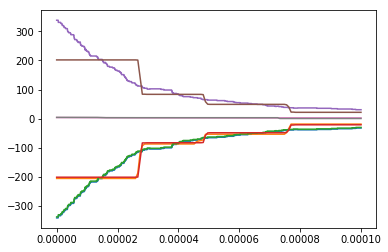

In [10]:
from readdy_learn.analyze.derivative import ld_derivative
traj = estimator.trajs[0]
X = np.linspace(0, 1, num=traj.n_time_steps) * dt

dt = traj.time_step
theta = estimator.get_theta(traj.counts)
theta = np.transpose(theta, axes=(0, 2, 1))
dx = theta.dot(desired_rates)
derivs = []
for s in range(traj.n_species):
    counts = traj.counts[:, s]
    counts = counts[::100]
    
    Dcounts = ld_derivative(counts, timestep*100, 1., maxit=200, verbose=True)
    derivs.append(Dcounts)
    plt.plot(X, dx[:, s])
    plt.plot(X[::100], Dcounts)
plt.show()

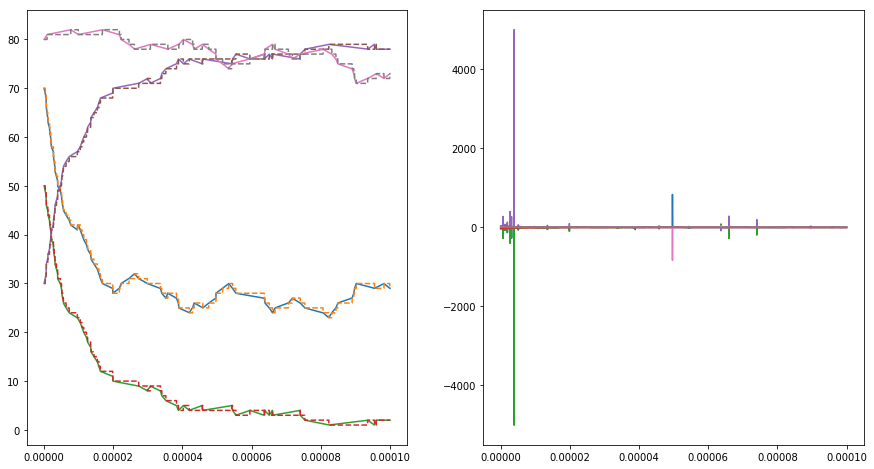

In [32]:
from scipy import interpolate
from scipy import optimize
traj = estimator.trajs[0]

dt = traj.time_step
X = np.linspace(0, 1, num=traj.n_time_steps) * dt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

theta = estimator.get_theta(traj.counts)
theta = np.transpose(theta, axes=(0, 2, 1))
dx = theta.dot(desired_rates)

for s in range(traj.n_species):
    counts = traj.counts[:, s]
    indices = 1 + np.where(counts[:-1] != counts[1:])[0]
    indices = np.insert(indices, 0, 0)
    indices = np.append(indices, len(counts) - 1)
    
    ff = np.interp(X, X[indices], counts[indices])
    ax1.plot(X, ff)
    ax1.plot(X, counts, '--')
    
    ax2.plot(X, np.gradient(ff, axis=0)/dt)
    ax2.plot(X, dx[:, s])
plt.show()

# come up with initial conditions

In [55]:
suite = Suite(set_up_system, tol=tol, interp_degree=interp_degree)

In [56]:
init_rates = suite.calculate("", [timestep], n_steps, save=False, verbose=True)

[KMC] [2017-10-24 10:44:09] [INFO] Simulate for 100 steps
[KMC] [2017-10-24 10:44:09] [INFO] got time step 0.0001 and n_frames 99215
[KMC] [2017-10-24 10:44:09] [INFO] Simulate for 100 steps
[KMC] [2017-10-24 10:44:09] [INFO] got time step 0.0001 and n_frames 134874


---- suite calculate parallel


[KMC] [2017-10-24 10:44:09] [INFO] Simulate for 100 steps
[KMC] [2017-10-24 10:44:09] [INFO] got time step 0.0001 and n_frames 159295
[KMC] [2017-10-24 10:44:10] [INFO] Simulate for 100 steps
[KMC] [2017-10-24 10:44:10] [INFO] got time step 0.0001 and n_frames 158324
[KMC] [2017-10-24 10:44:10] [INFO] Simulate for 100 steps
[KMC] [2017-10-24 10:44:10] [INFO] got time step 0.0001 and n_frames 176349
[KMC] [2017-10-24 10:44:10] [INFO] Simulate for 100 steps
[KMC] [2017-10-24 10:44:10] [INFO] got time step 0.0001 and n_frames 135499
[KMC] [2017-10-24 10:44:10] [INFO] Simulate for 100 steps
[KMC] [2017-10-24 10:44:10] [INFO] got time step 0.0001 and n_frames 141017
[KMC] [2017-10-24 10:44:10] [INFO] Simulate for 100 steps
[KMC] [2017-10-24 10:44:10] [INFO] got time step 0.0001 and n_frames 150820
[KMC] [2017-10-24 10:44:10] [INFO] Simulate for 100 steps
[KMC] [2017-10-24 10:44:10] [INFO] got time step 0.0001 and n_frames 155966
[KMC] [2017-10-24 10:44:10] [INFO] Simulate for 100 steps
[KMC

---- begin suite run


[KMC] [2017-10-24 10:44:11] [INFO] got time step 0.0001 and n_frames 99215
[KMC] [2017-10-24 10:44:11] [INFO] got time step 0.0001 and n_frames 134874


---- begin suite run
---- begin suite run


[KMC] [2017-10-24 10:44:11] [INFO] got time step 0.0001 and n_frames 159295


---- begin suite run


[KMC] [2017-10-24 10:44:11] [INFO] got time step 0.0001 and n_frames 158324


---- begin suite run


[KMC] [2017-10-24 10:44:11] [INFO] got time step 0.0001 and n_frames 176349


---- begin suite run


[KMC] [2017-10-24 10:44:11] [INFO] got time step 0.0001 and n_frames 141017


---- begin suite run
max counts = 82.0, min nonzero counts = 4.0


[KMC] [2017-10-24 10:44:11] [INFO] got time step 0.0001 and n_frames 135499


---- begin suite run


[KMC] [2017-10-24 10:44:11] [INFO] got time step 0.0001 and n_frames 150820


max counts = 82.0, min nonzero counts = 1.0
max counts = 83.0, min nonzero counts = 1.0
max counts = 87.0, min nonzero counts = 2.0
max counts = 85.0, min nonzero counts = 4.0
max counts = 86.0, min nonzero counts = 1.0
max counts = 84.0, min nonzero counts = 3.0
max counts = 82.0, min nonzero counts = 2.0
optimization problem did not exit successfully (alpha=0.0, lambda=1.0)!
status 8: Positive directional derivative for linesearch
6 / 30000 iterations
---- finish suite run, success = False
---- begin suite run


[KMC] [2017-10-24 10:44:13] [INFO] got time step 0.0001 and n_frames 155966


max counts = 84.0, min nonzero counts = 2.0
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
12 / 30000 iterations
---- finish suite run, success = True
---- begin suite run


[KMC] [2017-10-24 10:44:18] [INFO] got time step 0.0001 and n_frames 123468


optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
16 / 30000 iterations
---- finish suite run, success = True
---- begin suite run


[KMC] [2017-10-24 10:44:18] [INFO] got time step 0.0001 and n_frames 163258


optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
11 / 30000 iterations
---- finish suite run, success = True
max counts = 86.0, min nonzero counts = 5.0
---- begin suite run


[KMC] [2017-10-24 10:44:18] [INFO] got time step 0.0001 and n_frames 119156


optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
10 / 30000 iterations
---- finish suite run, success = True
---- begin suite run


[KMC] [2017-10-24 10:44:18] [INFO] got time step 0.0001 and n_frames 114088


max counts = 84.0, min nonzero counts = 3.0
max counts = 85.0, min nonzero counts = 1.0
max counts = 88.0, min nonzero counts = 4.0
optimization problem did not exit successfully (alpha=0.0, lambda=1.0)!
status 8: Positive directional derivative for linesearch
6 / 30000 iterations
---- finish suite run, success = False
---- begin suite run


[KMC] [2017-10-24 10:44:19] [INFO] got time step 0.0001 and n_frames 142644


optimization problem did not exit successfully (alpha=0.0, lambda=1.0)!
status 8: Positive directional derivative for linesearch
6 / 30000 iterations
---- finish suite run, success = False
---- begin suite run


[KMC] [2017-10-24 10:44:19] [INFO] got time step 0.0001 and n_frames 162524


max counts = 87.0, min nonzero counts = 2.0
max counts = 80.0, min nonzero counts = 1.0
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
15 / 30000 iterations
---- finish suite run, success = True
---- begin suite run


[KMC] [2017-10-24 10:44:20] [INFO] got time step 0.0001 and n_frames 139594


optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
13 / 30000 iterations
---- finish suite run, success = True
---- begin suite run


[KMC] [2017-10-24 10:44:20] [INFO] got time step 0.0001 and n_frames 152821


max counts = 80.0, min nonzero counts = 1.0
max counts = 81.0, min nonzero counts = 1.0
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
14 / 30000 iterations
---- finish suite run, success = True
---- begin suite run


[KMC] [2017-10-24 10:44:22] [INFO] got time step 0.0001 and n_frames 137091


max counts = 83.0, min nonzero counts = 1.0
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
11 / 30000 iterations
---- finish suite run, success = True
---- begin suite run


[KMC] [2017-10-24 10:44:23] [INFO] got time step 0.0001 and n_frames 184692


optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
17 / 30000 iterations
---- finish suite run, success = True
---- begin suite run


[KMC] [2017-10-24 10:44:23] [INFO] got time step 0.0001 and n_frames 133321


max counts = 83.0, min nonzero counts = 2.0
max counts = 81.0, min nonzero counts = 1.0
optimization problem did not exit successfully (alpha=0.0, lambda=1.0)!
status 8: Positive directional derivative for linesearch
6 / 30000 iterations
---- finish suite run, success = False
optimization problem did not exit successfully (alpha=0.0, lambda=1.0)!
status 8: Positive directional derivative for linesearch
8 / 30000 iterations
---- finish suite run, success = False
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
11 / 30000 iterations
---- finish suite run, success = True
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
12 / 30000 iterations
---- finish suite run, success = True
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
14 / 30000 iterations
---- finish suite run, success = True
optimi

In [57]:
# init_rates = [.02, .02, 1e-3, 1e-3, 0, 0]
print("initial rates: {}".format(init_rates))

initial rates: [ 0.05322712  0.0344649   0.00987523  0.01170214  0.00015818  0.00020807]


[KMC] [2017-10-24 10:44:28] [INFO] got time step 0.0001 and n_frames 130236


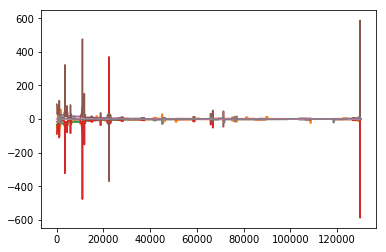

In [58]:
estimator = suite.get_estimator(train_system, bfc, timestep, interp_degree=interp_degree)
data, expected = estimator._get_slice(None)
theta = estimator.get_theta(data)
theta = np.transpose(theta, axes=(0, 2, 1))
dx = theta.dot(init_rates)
for species in range(4):
    xx = dx[:, species]
    plt.plot(xx)
    xx = expected[:, species]
    plt.plot(xx)
plt.show()

# perform cv

In [59]:
alphas = np.linspace(0, 200, num=512)
l1_ratios = np.array([1.0]) # np.linspace(0, 1, num=3)
cv = CV(train_traj, bfc, alphas, l1_ratios, 5, init_rates, test_traj=test_trajs, maxiter=3000000, rescale=False, 
        tol=tol)

In [60]:
cv.fit_cross_trajs()

IntProgress(value=0, max=511)

In [61]:
def plot_cv_results(cv):
    xs = []
    ys = []
    for r in cv.result:
        if len(r['scores']) > 0:
            xs.append(r['alpha'])
            ys.append(r['scores'][0])
    xs = np.array(xs)
    ys = np.array(ys)
    sorts = np.argsort(xs)
    xs = xs[sorts]
    ys = ys[sorts]
    plt.plot(xs, np.sqrt(-ys))
    plt.show()

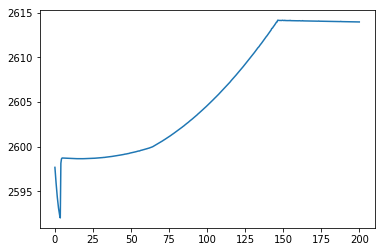

In [62]:
plot_cv_results(cv)

In [63]:
def best_params(cv):
    current_best_score = -1
    alpha = -1
    l1_ratio = -1
    for r in cv.result:
        if len(r['scores']) > 0:
            if current_best_score >= 0:
                if -np.mean(r['scores']) < current_best_score:
                    current_best_score = np.mean(r['scores'])
                    alpha = r['alpha']
                    l1_ratio = r['l1_ratio']
            else:
                current_best_score = -np.mean(r['scores'])
                alpha = r['alpha']
                l1_ratio = r['l1_ratio']
    return alpha, l1_ratio

In [64]:
alpha, l1_ratio = best_params(cv)
print("params: alpha={}, l1={}".format(alpha, l1_ratio))

params: alpha=3.522504892367906, l1=1.0


In [65]:
suite = Suite(set_up_system, maxiter=300000, alpha=alpha, l1_ratio=l1_ratio, tol=tol, interp_degree=interp_degree,
              init_xi=init_rates)
rates = suite.calculate("", [timestep], n_steps, save=False, verbose=False, n_realizations=10)

[KMC] [2017-10-24 10:48:02] [INFO] Simulate for 100 steps
[KMC] [2017-10-24 10:48:03] [INFO] got time step 0.0001 and n_frames 149554
[KMC] [2017-10-24 10:48:03] [INFO] Simulate for 100 steps
[KMC] [2017-10-24 10:48:03] [INFO] got time step 0.0001 and n_frames 142547
[KMC] [2017-10-24 10:48:03] [INFO] Simulate for 100 steps
[KMC] [2017-10-24 10:48:03] [INFO] got time step 0.0001 and n_frames 125572
[KMC] [2017-10-24 10:48:03] [INFO] Simulate for 100 steps
[KMC] [2017-10-24 10:48:03] [INFO] got time step 0.0001 and n_frames 162171
[KMC] [2017-10-24 10:48:03] [INFO] Simulate for 100 steps
[KMC] [2017-10-24 10:48:03] [INFO] got time step 0.0001 and n_frames 161502
[KMC] [2017-10-24 10:48:03] [INFO] Simulate for 100 steps
[KMC] [2017-10-24 10:48:03] [INFO] got time step 0.0001 and n_frames 125025
[KMC] [2017-10-24 10:48:03] [INFO] Simulate for 100 steps
[KMC] [2017-10-24 10:48:03] [INFO] got time step 0.0001 and n_frames 107711
[KMC] [2017-10-24 10:48:03] [INFO] Simulate for 100 steps
[KMC

In [66]:
print(rates)

[ 0.01308662  0.01055174  0.01129886  0.00649519  0.00722403  0.00012407]


In [45]:
print(desired_rates)

[ 0.02  0.02  0.01  0.01  0.    0.  ]


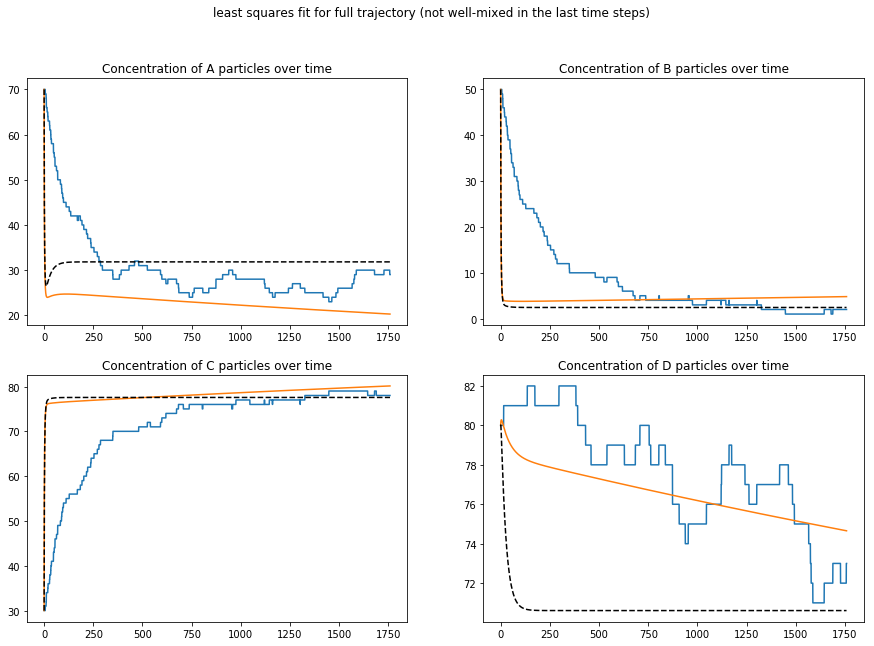

In [70]:
from scipy.integrate import odeint
def fun(data, _):
    theta = np.array([f(data) for f in bfc.functions])
    return np.matmul(rates, theta)
def fun_reference(data, _):
    theta = np.array([f(data) for f in bfc.functions])
    return np.matmul(desired_rates, theta)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("least squares fit for full trajectory (not well-mixed in the last time steps)")
num_solution = odeint(fun, traj.counts[0], np.arange(0, traj.n_time_steps*.01, .01))
reference_soln = odeint(fun_reference, traj.counts[0], np.arange(0, traj.n_time_steps*.01, .01))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), traj.counts[:,i])
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), num_solution[:, i])
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), reference_soln[:, i], 'k--')
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.show()